In [1]:
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
import numpy as np
import math
import cv2
import os
from scipy.linalg import eigh
from sklearn.cluster import KMeans

In [2]:
def downsample(image , n, m):
    scaling_factorx = n / image.shape[1]
    scaling_factory = m / image.shape[0]

    resized_image = cv2.resize(image, None, fx=scaling_factorx, fy=scaling_factory , interpolation=cv2.INTER_AREA)

    return resized_image

In [3]:
image1 = cv2.imread('./Images/image1.jpg')
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

image2 = cv2.imread('./Images/image2.jpg')
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

print(image1.shape,image2.shape)

(219, 327, 3) (460, 736, 3)


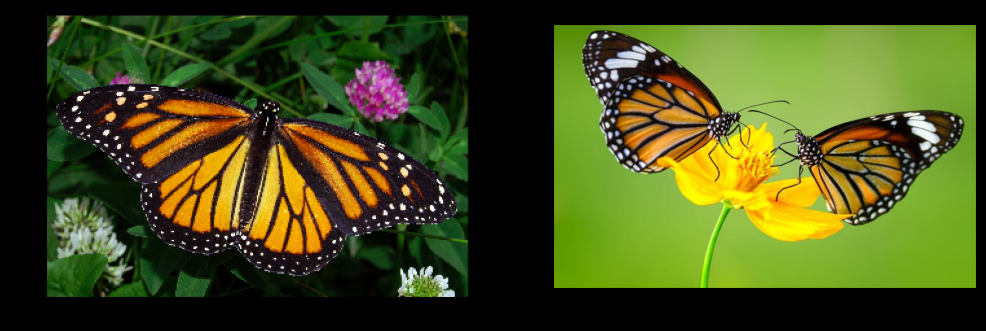

In [4]:
fig = plt.figure(figsize=(12,10),facecolor='black')

fig.add_subplot(1,2,1)
plt.imshow(image1)
fig.add_subplot(1,2,2)
plt.imshow(image2)

plt.show()

### K-Means

In [6]:
def kmeans_segmentation(image_to_be_segmented, k, eps):
    image = image_to_be_segmented.copy()

    # Converting pixel values to float32
    pixel_values = np.float32(image.reshape((-1,3)))

    # Applying KMeans and getting back tuple of results (total min sq distance attained form centroids, labels, centers)
    return_val1, labels, centers = cv2.kmeans(data=pixel_values,
                                              K=k,
                                              bestLabels=None,
                                              criteria=(cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS,1000,eps),
                                              attempts=10,
                                              flags=cv2.KMEANS_RANDOM_CENTERS)

    # Centers have to be of type non negative int
    centers = np.uint8(centers)

    segmented_data = centers[labels.flatten()]

    segmented_image = segmented_data.reshape((image.shape))

    return segmented_image

### Kmeans on Original Images

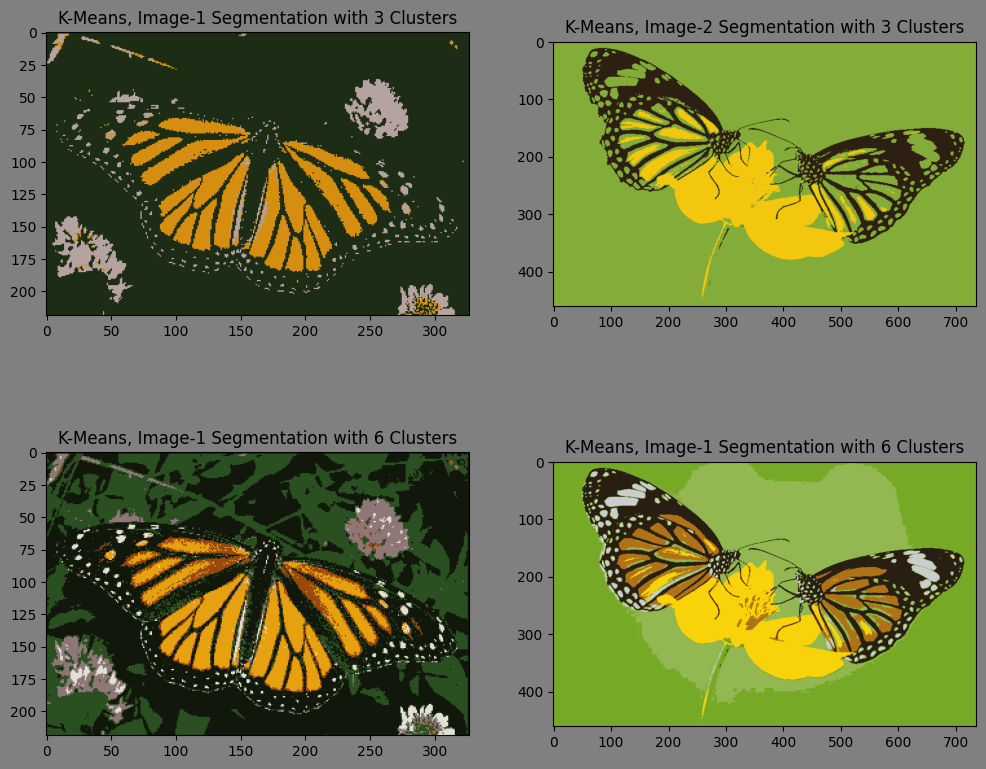

In [7]:
segmented_image1_3_clusters = kmeans_segmentation(image1,3,0.85)
segmented_image2_3_clusters = kmeans_segmentation(image2,3,0.85)

segmented_image1_6_clusters = kmeans_segmentation(image1,6,0.85)
segmented_image2_6_clusters = kmeans_segmentation(image2,6,0.85)

fig = plt.figure(figsize=(12,10),facecolor='gray')

fig.add_subplot(2,2,1)
plt.title('K-Means, Image-1 Segmentation with 3 Clusters')
plt.imshow(segmented_image1_3_clusters)

fig.add_subplot(2,2,2)
plt.title('K-Means, Image-2 Segmentation with 3 Clusters')
plt.imshow(segmented_image2_3_clusters)

fig.add_subplot(2,2,3)
plt.title('K-Means, Image-1 Segmentation with 6 Clusters')
plt.imshow(segmented_image1_6_clusters)

fig.add_subplot(2,2,4)
plt.title('K-Means, Image-1 Segmentation with 6 Clusters')
plt.imshow(segmented_image2_6_clusters)


plt.show()

#### Downsampling Images for Ratio-Cut

In [8]:
image1_64x64 = downsample(image1, 64, 64)
image2_64x64 = downsample(image2, 64, 64)

### Original Images after Downsampling

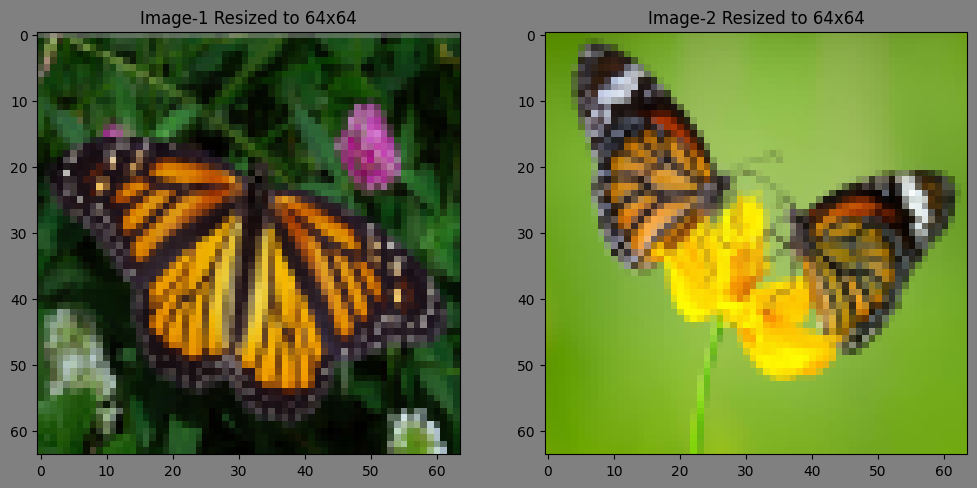

In [9]:
fig = plt.figure(figsize=(12,10),facecolor='gray')

fig.add_subplot(1,2,1)
plt.title('Image-1 Resized to 64x64')
plt.imshow(image1_64x64)

fig.add_subplot(1,2,2)
plt.title('Image-2 Resized to 64x64')
plt.imshow(image2_64x64)

plt.show()

In [10]:
image1_64x64 = np.int32(image1_64x64)
image2_64x64 = np.int32(image2_64x64)

In [11]:
image1_64x64_flattened = image1_64x64.reshape((-1,3))
image2_64x64_flattened = image2_64x64.reshape((-1,3))

In [12]:
def calculate_adj_matrix(image , sigma_sq , lambda_val):
    img = image.copy()
    n = img.shape[0]

    W = np.ones((n,n))
    for i in range(n):
        for j in range(i+1,n):
            # For diff in colour
            d_colour_ij = 0
            for k in range(len(img[i])):
                d_colour_ij += (img[i][k] - img[j][k])**2

            # For difference in pixel coords
            d_coord_ij = ((i//64) - (j//64))**2
            d_coord_ij += ((i%64) - (j%64))**2

            # Lambda = 0.5
            wt = d_colour_ij + lambda_val*d_coord_ij

            W[i][j] = np.exp(-wt/sigma_sq)
            W[j][i] = W[i][j]

    return W

def ratio_cut_clustering(image,W,k,eps):
    n = W.shape[0]

    D = np.zeros((n,n))
    for i in range(n): D[i][i] = np.sum(W[i])

    L = D - W

    e_val , e_vec = eigh(L)
    sorted_indices = np.argsort(e_val)
    e_val,e_vec = e_val[sorted_indices] , e_vec[:, sorted_indices]
    print("e_val:" , e_val)

    H = e_vec[:, 1:(1+k)]
    H = np.float32(H)

    return_val , labels , centers = cv2.kmeans(H, k, None, (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,100,eps), 100, cv2.KMEANS_RANDOM_CENTERS)
    
    labels = list(labels.flatten())
    counts = Counter(labels)

    centers = np.zeros((len(set(labels)),3))

    for i in range(len(labels)): centers[labels[i]] += image[i]
    for i in counts: centers[i] /= counts[i]

    centers = np.uint(centers)
    print(centers)
    data = centers[np.array(labels).flatten()]

    seg_img = data.reshape((64,64,3))

    return seg_img

### For Image-1

e_val: [-5.03430488e-14  3.27157729e-01  8.97934671e-01 ...  1.11228472e+03
  1.11314126e+03  1.11355673e+03]
[[169 100 155]
 [230 205 159]
 [ 61  64  26]]


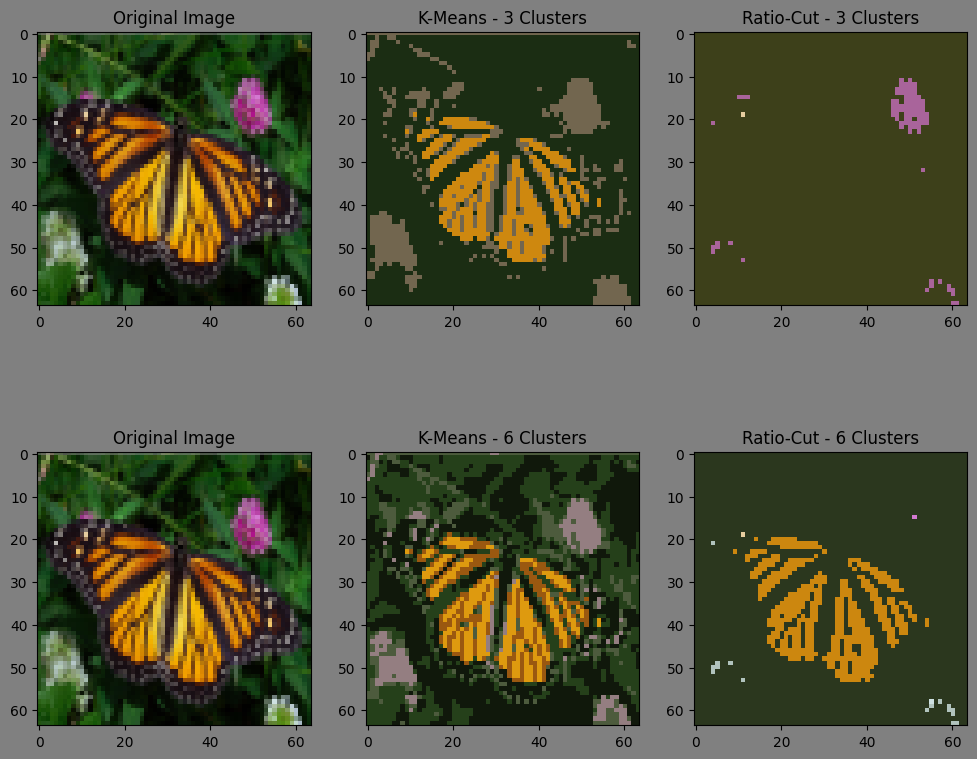

In [36]:
segmented_image1_3_clusters_kmeans = kmeans_segmentation(image_to_be_segmented=image1_64x64,k=3,eps=0.85)
segmented_image1_6_clusters_kmeans = kmeans_segmentation(image_to_be_segmented=image1_64x64,k=6,eps=0.85)

W_img1_3_clusters=calculate_adj_matrix(image1_64x64_flattened,sigma_sq=900,lambda_val=0.01)
segmented_image1_3_clusters_ratio_cut = ratio_cut_clustering(image=image1_64x64_flattened,
                                                             W=W_img1_3_clusters,
                                                             k=3,
                                                             eps=0.00028)

W_img1_6_clusters=calculate_adj_matrix(image1_64x64_flattened,sigma_sq=1225,lambda_val=0.01)
segmented_image1_6_clusters_ratio_cut = ratio_cut_clustering(image=image1_64x64_flattened,
                                                             W=W_img1_6_clusters,
                                                             k=6,
                                                             eps=0.0028)

fig = plt.figure(figsize=(12,10),facecolor='gray')

fig.add_subplot(2,3,1)
plt.title('Original Image')
plt.imshow(image1_64x64)

fig.add_subplot(2,3,2)
plt.title('K-Means - 3 Clusters')
plt.imshow(segmented_image1_3_clusters_kmeans)

fig.add_subplot(2,3,3)
plt.title('Ratio-Cut - 3 Clusters')
plt.imshow(segmented_image1_3_clusters_ratio_cut)

fig.add_subplot(2,3,4)
plt.title('Original Image')
plt.imshow(image1_64x64)

fig.add_subplot(2,3,5)
plt.title('K-Means - 6 Clusters')
plt.imshow(segmented_image1_6_clusters_kmeans)

fig.add_subplot(2,3,6)
plt.title('Ratio-Cut - 6 Clusters')
plt.imshow(segmented_image1_6_clusters_ratio_cut)

### For Image-2

e_val: [9.74087684e-13 4.24651057e-01 2.34897513e+00 ... 1.62744851e+03
 1.62782525e+03 1.62791344e+03]
[[ 70  57  42]
 [244 205   8]
 [242 185 116]
 [247 251 252]
 [131 169  51]
 [175 179 190]]


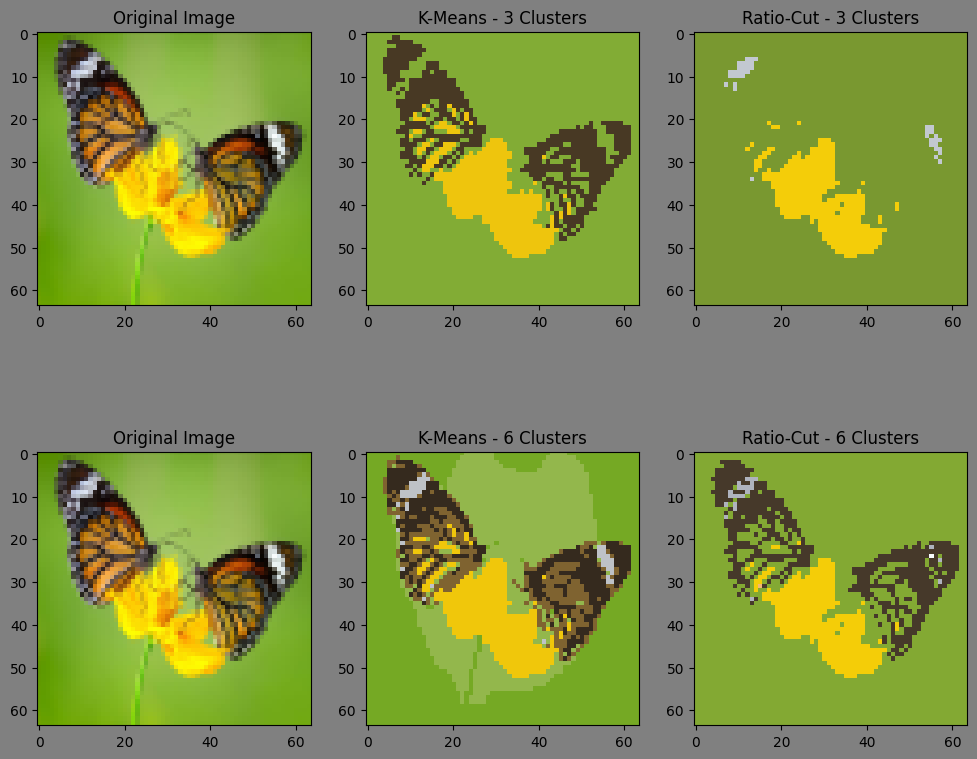

In [34]:
segmented_image2_3_clusters_kmeans = kmeans_segmentation(image2_64x64,3,0.85)
segmented_image2_6_clusters_kmeans = kmeans_segmentation(image2_64x64,6,0.85)

W_img2_3_clusters=calculate_adj_matrix(image2_64x64_flattened,sigma_sq=1225,lambda_val=0.01)
segmented_image2_3_clusters_ratio_cut = ratio_cut_clustering(image=image2_64x64_flattened,
                                                             W=W_img2_3_clusters,
                                                             k=3,
                                                             eps=0.0028)

W_img2_6_clusters=calculate_adj_matrix(image2_64x64_flattened,sigma_sq=1225,lambda_val=0.01)
segmented_image2_6_clusters_ratio_cut = ratio_cut_clustering(image=image2_64x64_flattened, 
                                                             W=W_img2_6_clusters,
                                                             k=6,
                                                             eps=0.0028)

fig = plt.figure(figsize=(12,10),facecolor='gray')

fig.add_subplot(2,3,1)
plt.title('Original Image')
plt.imshow(image2_64x64)

fig.add_subplot(2,3,2)
plt.title('K-Means - 3 Clusters')
plt.imshow(segmented_image2_3_clusters_kmeans)

fig.add_subplot(2,3,3)
plt.title('Ratio-Cut - 3 Clusters')
plt.imshow(segmented_image2_3_clusters_ratio_cut)

fig.add_subplot(2,3,4)
plt.title('Original Image')
plt.imshow(image2_64x64)

fig.add_subplot(2,3,5)
plt.title('K-Means - 6 Clusters')
plt.imshow(segmented_image2_6_clusters_kmeans)

fig.add_subplot(2,3,6)
plt.title('Ratio-Cut - 6 Clusters')
plt.imshow(segmented_image2_6_clusters_ratio_cut)